In [1]:
import os 
root_dir = os.path.abspath('')
os.chdir(root_dir)

# Library

In [281]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from src.eda import *
from src.feat_select import *

In [128]:
pd.set_option('display.max_rows', 150)
pd.set_option('display.max_columns', 50)

In [4]:
import importlib
from src import eda
importlib.reload(eda)
from src.eda import *

In [5]:
df = pd.read_csv('data/train_data.txt')
df_test = pd.read_csv('data/test_data.txt')

In [6]:
print('Train: ', len(df))
print('Test: ', len(df_test))

Train:  5822
Test:  4000


In [7]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 87 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   ID      5822 non-null   int64
 1   1       5822 non-null   int64
 2   2       5822 non-null   int64
 3   3       5822 non-null   int64
 4   4       5822 non-null   int64
 5   5       5822 non-null   int64
 6   6       5822 non-null   int64
 7   7       5822 non-null   int64
 8   8       5822 non-null   int64
 9   9       5822 non-null   int64
 10  10      5822 non-null   int64
 11  11      5822 non-null   int64
 12  12      5822 non-null   int64
 13  13      5822 non-null   int64
 14  14      5822 non-null   int64
 15  15      5822 non-null   int64
 16  16      5822 non-null   int64
 17  17      5822 non-null   int64
 18  18      5822 non-null   int64
 19  19      5822 non-null   int64
 20  20      5822 non-null   int64
 21  21      5822 non-null   int64
 22  22      5822 non-null   int64
 23  23      5822 

In [8]:
demo_feat = [str(i) for i in range(1,43)]
prod_own_feat = [str(i) for i in range(43, 86)]
label = ['86']

In [142]:
def regroup(row):
    if row in (1,2,3,4,7):
        return 3
    elif row in (8,9,10,11,12,13,14,15,22,26,27,28,29,30,34,35,36,37,38):
        return 2
    elif row in (16,17,18,19,21,23,24,25,31,33,41):
        return 1
    else:
        return 0

In [145]:
df['social_class'] = df['1'].apply(lambda row: regroup(row)) 

# Data processing + Feature creation

In [11]:
def most_cat(df, feature):
    total_obs = len(df)
    most_cat = df[feature].value_counts().max()
    rate = most_cat/total_obs
    return rate

In [12]:
frequency_rate = {'feature':[], 'rate':[]}
for feature in (demo_feat+prod_own_feat):
    frequency_rate['feature'].append(feature)
    frequency_rate['rate'].append(most_cat(df, feature))

In [13]:
freq_rate = pd.DataFrame(frequency_rate).sort_values(by='rate', ascending=False).reset_index(drop=True)
drop_list = list(freq_rate[freq_rate['rate']>= 0.8].feature)

In [14]:
#total contribution level/amount
df['total_con_level'] = df.iloc[:, 44:66].sum(axis=1)

#total number of policy owned
df['total_no_policy'] = df.iloc[:, 65:86].sum(axis=1)

#total amount contributed per policies
for amt, count in zip(range(44,65), range(65,86)):
    df[f'{amt}_amt'] = df[f'{amt}']*df[f'{count}']

In [15]:
#scan to see which policies have the most contribution/ownership amount

df.iloc[:, 90:111].sum(axis=0).sort_values(ascending=False)

#47 = car insurance
#59 = fire insurance
#44 = private 3rd party insurance
#55 = life insurance

47_amt    19142
59_amt    11388
44_amt     4507
55_amt     1765
54_amt     1305
49_amt     1124
52_amt      804
46_amt      417
48_amt      366
64_amt      280
45_amt      257
62_amt      185
58_amt      161
51_amt      152
53_amt      151
61_amt      118
63_amt       95
57_amt       89
50_amt       85
56_amt       80
60_amt        5
dtype: int64

In [16]:
#total amount all policies
df['total_all_policy'] = df.iloc[:, 90:111].sum(axis=1)

def treat_divide_by_zero(df, feat):
    set_limit = df[df[feat]!=np.inf][feat].max()
    df[feat] = df[feat].replace({np.inf:set_limit, -np.inf:0})

#ratio average income/total amount all policies
df['income_vs_policy'] = df['42']/df['total_all_policy']
treat_divide_by_zero(df, 'income_vs_policy')

#ratio average income/insurance type (most popular types)
for i in [47,59,44,55]:
    new_col = f'income_vs{i}'
    df[new_col]=df['42']/df[f'{i}_amt']
    treat_divide_by_zero(df, new_col)

df.fillna(0, inplace=True)

In [18]:
def data_processing(df):
    #total contribution level/amount
    df['total_con_level'] = df.iloc[:, 44:66].sum(axis=1)
    
    #total number of policy owned
    df['total_no_policy'] = df.iloc[:, 65:86].sum(axis=1)
    
    #total amount contributed per policies
    for amt, count in zip(range(44,65), range(65,86)):
        df[f'{amt}_amt'] = df[f'{amt}']*df[f'{count}']
    #total amount all policies
    df['total_all_policy'] = df.iloc[:, 90:111].sum(axis=1)
    
    def treat_divide_by_zero(df, feat):
        set_limit = df[df[feat]!=np.inf][feat].max()
        df[feat] = df[feat].replace({np.inf:set_limit, -np.inf:0})
    
    #ratio average income/total amount all policies
    df['income_vs_policy'] = df['42']/df['total_all_policy']
    treat_divide_by_zero(df, 'income_vs_policy')
    
    #ratio average income/insurance type (most popular types)
    for i in [47,59,44,55]:
        new_col = f'income_vs{i}'
        df[new_col]=df['42']/df[f'{i}_amt']
        treat_divide_by_zero(df, new_col)

    df.fillna(0, inplace=True)        
    return df

# EDA

In [19]:
df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 117 columns):
 #    Column            Non-Null Count  Dtype  
---   ------            --------------  -----  
 0    ID                5822 non-null   int64  
 1    1                 5822 non-null   int64  
 2    2                 5822 non-null   int64  
 3    3                 5822 non-null   int64  
 4    4                 5822 non-null   int64  
 5    5                 5822 non-null   int64  
 6    6                 5822 non-null   int64  
 7    7                 5822 non-null   int64  
 8    8                 5822 non-null   int64  
 9    9                 5822 non-null   int64  
 10   10                5822 non-null   int64  
 11   11                5822 non-null   int64  
 12   12                5822 non-null   int64  
 13   13                5822 non-null   int64  
 14   14                5822 non-null   int64  
 15   15                5822 non-null   int64  
 16   16                5822

<Figure size 640x480 with 0 Axes>

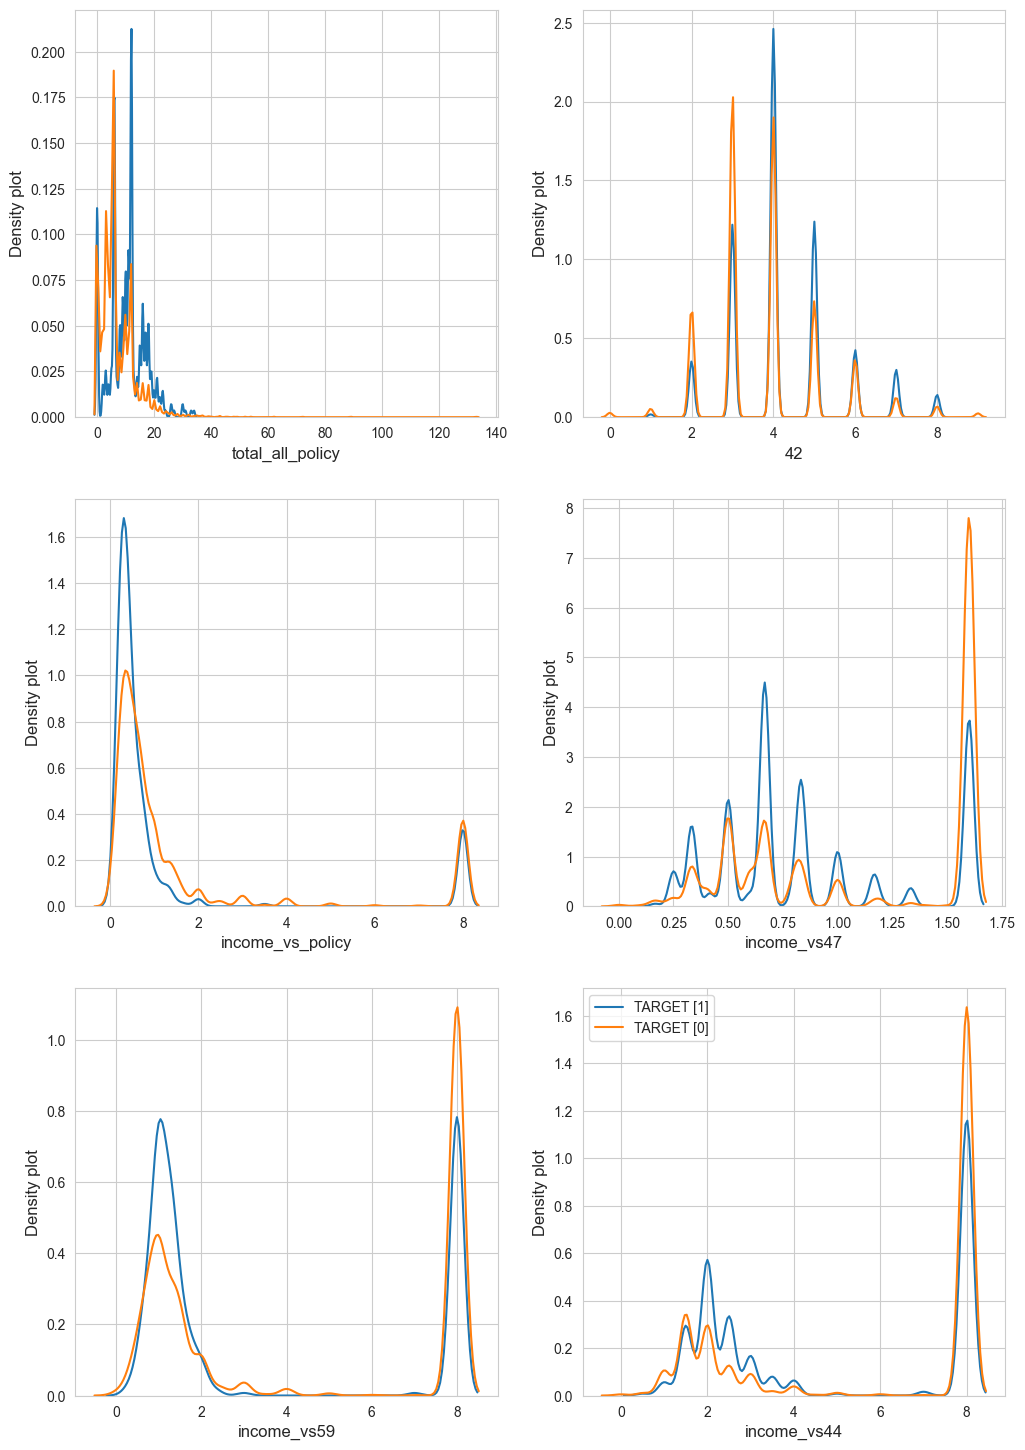

In [20]:
plot_distribution_target(df, ['total_all_policy', '42', 'income_vs_policy', 'income_vs47', 'income_vs59', 'income_vs44'], label[0], nrows=3, bw_method=0.05)

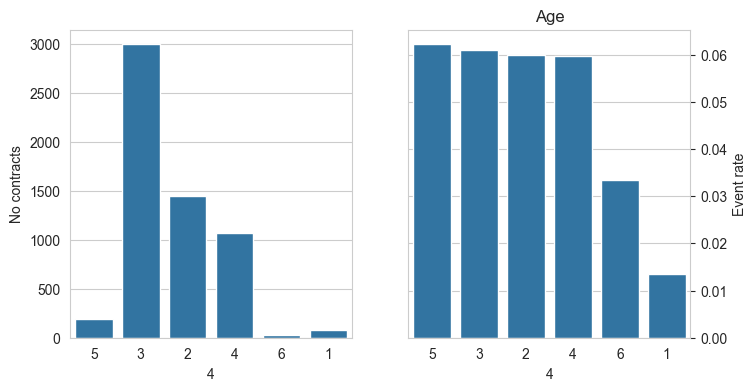

In [21]:
plot_stats('4', label[0], df, title='Age')

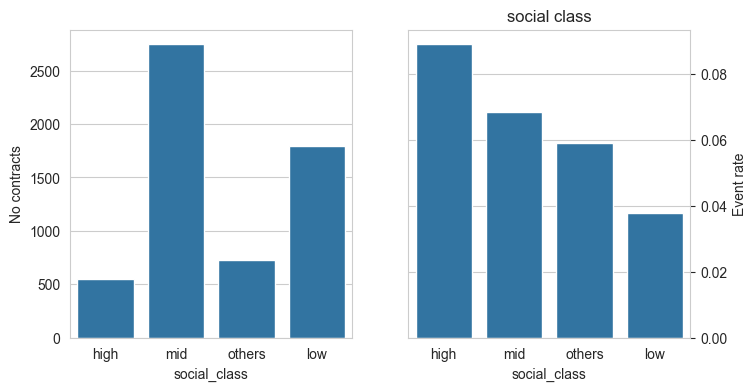

In [22]:
plot_stats('social_class', label[0], df, title='social class')

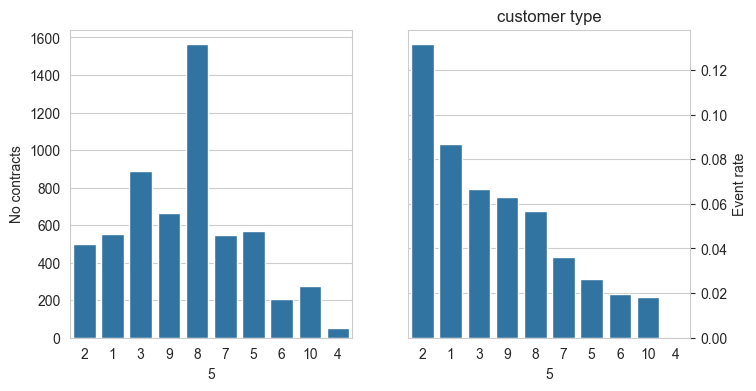

In [23]:
plot_stats('5', label[0], df, title='customer type')

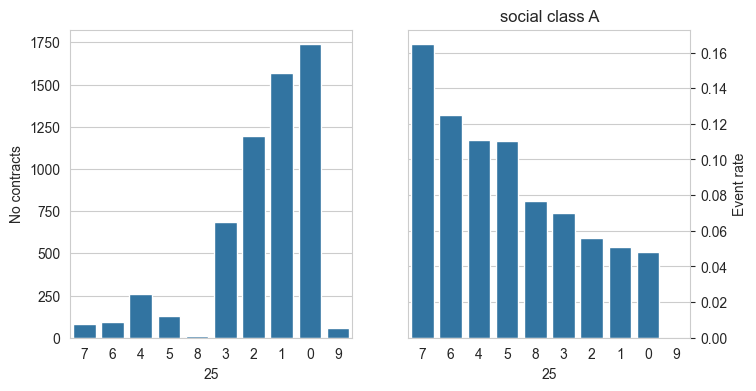

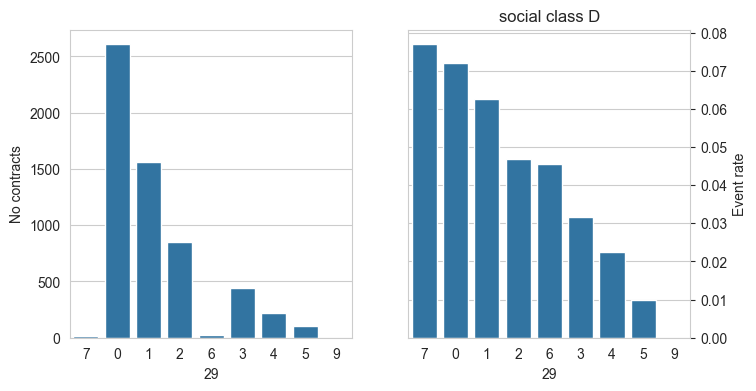

In [24]:
plot_stats('25', label[0], df, title='social class A')
plot_stats('29', label[0], df, title='social class D')

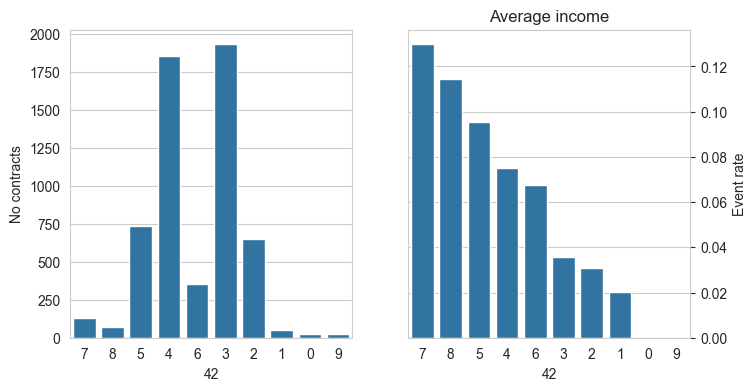

In [25]:
plot_stats('42', label[0], df, title='Average income')

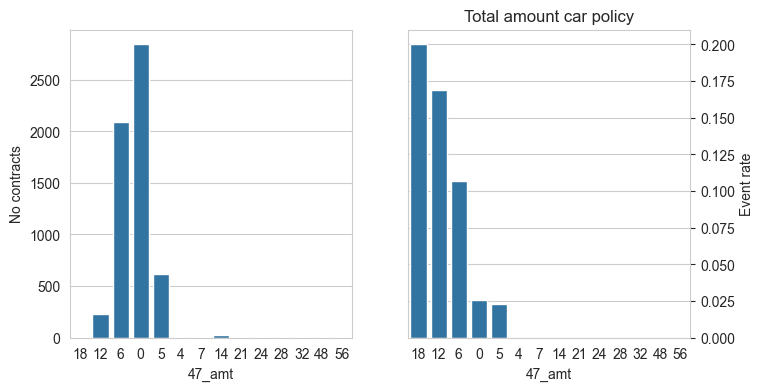

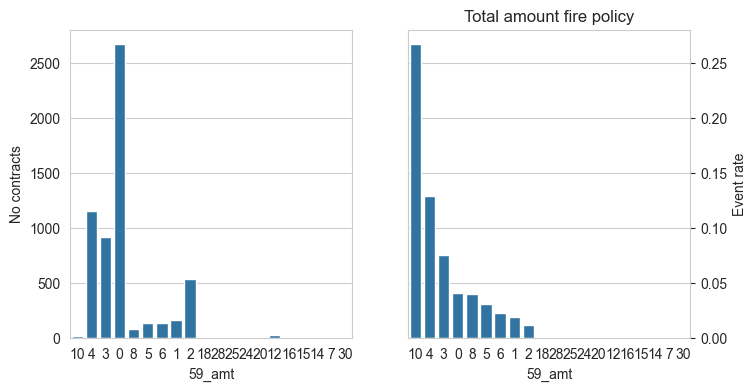

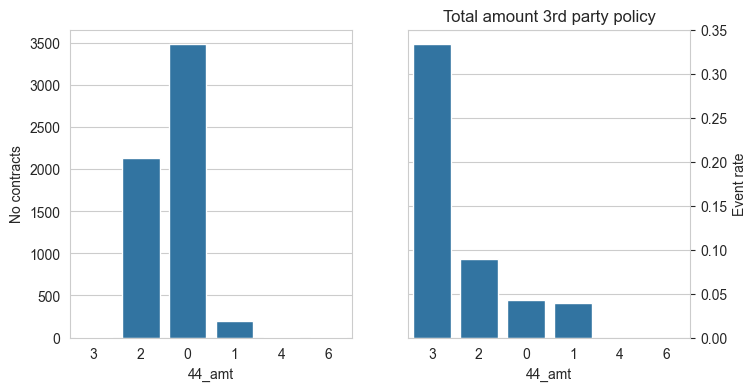

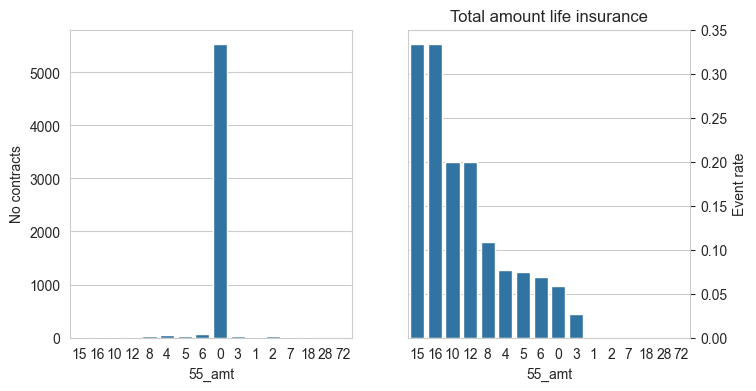

In [26]:
plot_stats('47_amt', label[0], df, title='Total amount car policy')
plot_stats('59_amt', label[0], df, title='Total amount fire policy')
plot_stats('44_amt', label[0], df, title='Total amount 3rd party policy')
plot_stats('55_amt', label[0], df, title='Total amount life insurance')

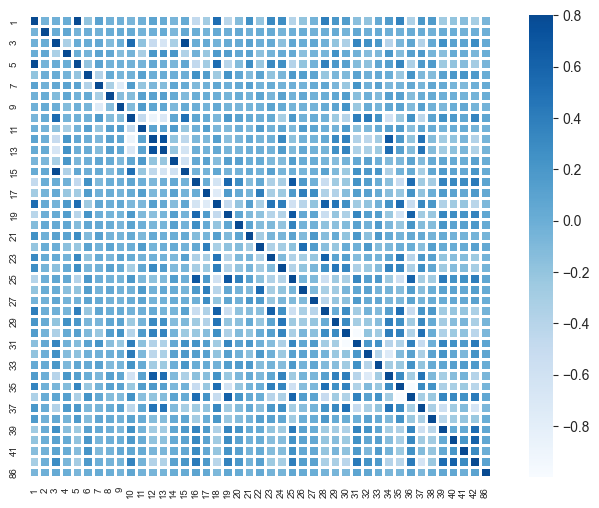

In [27]:
plot_corr_matrix(df[demo_feat+label])

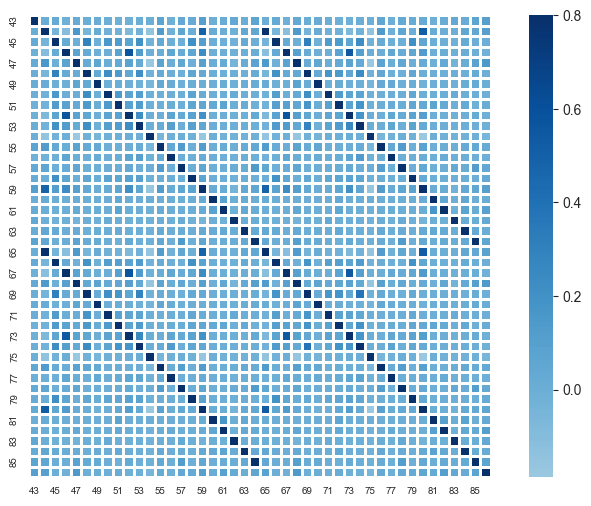

In [28]:
plot_corr_matrix(df[prod_own_feat+label])

# Feature selection

In [46]:
import optbinning
from optbinning import OptimalBinning
from sklearn.feature_selection import f_classif, chi2

In [31]:
feature_list_1 = list(set(df.columns) - set(['ID']+label) - set(drop_list))

In [32]:
len(feature_list_1)

77

In [33]:
df[feature_list_1].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 77 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   50_amt            5822 non-null   int64  
 1   9                 5822 non-null   int64  
 2   56_amt            5822 non-null   int64  
 3   38                5822 non-null   int64  
 4   63_amt            5822 non-null   int64  
 5   51_amt            5822 non-null   int64  
 6   18                5822 non-null   int64  
 7   58_amt            5822 non-null   int64  
 8   28                5822 non-null   int64  
 9   36                5822 non-null   int64  
 10  44_amt            5822 non-null   int64  
 11  32                5822 non-null   int64  
 12  1                 5822 non-null   int64  
 13  59                5822 non-null   int64  
 14  income_vs55       5797 non-null   float64
 15  45_amt            5822 non-null   int64  
 16  34                5822 non-null   int64  


In [47]:
df['income_vs59'].dtype == 'float'

True

In [61]:
np.array(df['income_vs59']).reshape(-1, 1)

array([[0.8 ],
       [2.5 ],
       [1.5 ],
       ...,
       [0.75],
       [8.  ],
       [8.  ]])

In [282]:
stat_table = feature_ranking(df, label[0], feature_list3)

100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 22.67it/s]


In [283]:
stat_table

,feature,iv,pval_test
0,59_amt,0.355700,4.213306e-20
1,37,0.167709,2.502371e-15
2,24,0.064036,3.381373e-06
3,47_amt,0.586539,4.640674e-112
4,9,0.036968,4.858092e-03
5,5,0.219847,3.255579e-10
6,40,0.069278,8.453583e-09
7,7,0.030101,4.547497e-02
8,19,0.062618,8.782534e-11
9,42,0.206545,3.146924e-06


In [102]:
filter_result = stat_table.query("iv > 0.02")\
            .query("pval_test <= 0.05|pval_test.isnull()")

In [105]:
feature_list_2 = list(filter_result['feature'])

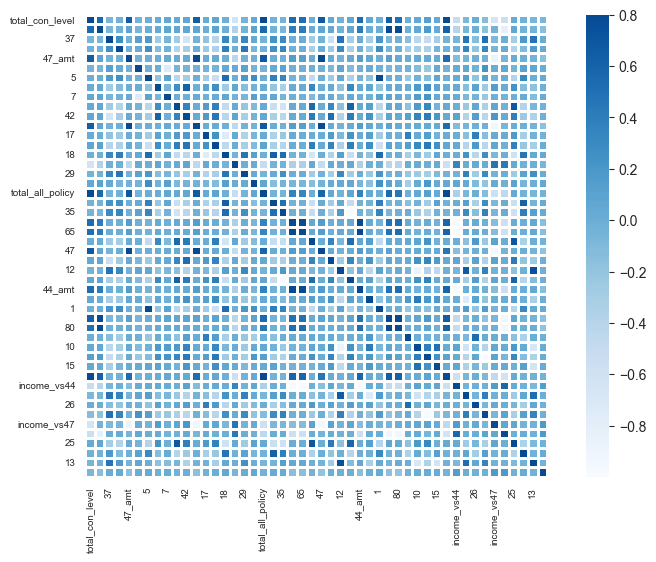

In [113]:
plot_corr_matrix(df[list(set(feature_list_2) - set(['social_class']))])

In [119]:
co = df[list(set(feature_list_2) - set(['social_class']))].corr().abs()

In [126]:
co_df = pd.DataFrame(co.unstack(), columns=['corr'])

In [173]:
co_df.query('corr > 0.9 & corr <1')

corr
total_con_level  total_no_policy   0.911536
59_amt           59                0.906280
                 80                0.906486
47_amt           68                0.992464
5                1                 0.992672
68               47_amt            0.992464
                 47                0.916154
                 income_vs47       0.909961
total_all_policy total_no_policy   0.918721
35               36                0.999239
44               65                0.981369
                 44_amt            0.995538
                 income_vs44       0.983172
65               44                0.981369
                 44_amt            0.980246
                 income_vs44       0.980709
47               68                0.916154
                 income_vs47       0.945492
36               35                0.999239
44_amt           44                0.995538
                 65                0.980246
                 income_vs44       0.977167
1                5                 0.992672
59               59_amt            0.906280
                 income_vs59       0.929065
80               59_amt            0.906486
                 income_vs59       0.932588
31               30                0.999554
total_no_policy  total_con_level   0.911536
                 total_all_policy  0.918721
income_vs44      44                0.983172
                 65                0.980709
                 44_amt            0.977167
30               31                0.999554
income_vs47      68                0.909961
                 47                0.945492
income_vs59      59                0.929065
                 80                0.932588

In [132]:
drop_list2 = ['total_con_level', 
              '59', 'income_vs59'
              '68', '1',
              '35', 
              '44', '65', 'income_vs44',
              '47', 'income_vs47',
             '30']

In [133]:
len(drop_list2)

11

In [139]:
feature_list3 = list(set(feature_list_2)-set(drop_list2))

In [149]:
df[feature_list3].info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 39 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   59_amt            5822 non-null   int64  
 1   37                5822 non-null   int64  
 2   24                5822 non-null   int64  
 3   47_amt            5822 non-null   int64  
 4   9                 5822 non-null   int64  
 5   5                 5822 non-null   int64  
 6   40                5822 non-null   int64  
 7   7                 5822 non-null   int64  
 8   19                5822 non-null   int64  
 9   42                5822 non-null   int64  
 10  68                5822 non-null   int64  
 11  17                5822 non-null   int64  
 12  43                5822 non-null   int64  
 13  18                5822 non-null   int64  
 14  income_vs_policy  5819 non-null   float64
 15  29                5822 non-null   int64  
 16  21                5822 non-null   int64  


# Training and evaluation

In [238]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble  import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import cross_val_score

from catboost import CatBoostClassifier
import optuna
import lightgbm as lgb
from lightgbm import LGBMClassifier

In [273]:
X = df[feature_list3]
y = df[label[0]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=1000)

In [166]:
for i in [180, 190, 200, 210, 230, 250, 270, 290]:
    clf = RandomForestClassifier(n_estimators = i)
    clf.fit(X_train, y_train)
    y_pred = clf.predict_proba(X_test)
    accuracy = metrics.roc_auc_score(y_test, y_pred)
    print(f"N_estimator {i} - AUC: {accuracy}", )

N_estimator 180 - AUC: 0.7143856213721239
N_estimator 190 - AUC: 0.7207788423432873
N_estimator 200 - AUC: 0.6984054829009022
N_estimator 210 - AUC: 0.7169207636897685
N_estimator 230 - AUC: 0.7210352705317389
N_estimator 250 - AUC: 0.7101195887824323
N_estimator 270 - AUC: 0.7088549315802969
N_estimator 290 - AUC: 0.7053057323355946


In [253]:
for i in [20, 50, 100, 200, 300, 500, 800, 1000]:
    clf = RandomForestClassifier(n_estimators = i)
    clf.fit(X_train, y_train)
    y_pred = clf.predict_proba(X_test)[:, 1]
    accuracy = metrics.roc_auc_score(y_test, y_pred)
    print(f"N_estimator {i} - AUC: {accuracy}", )

N_estimator 20 - AUC: 0.6576800242441198
N_estimator 50 - AUC: 0.7195491526213954
N_estimator 100 - AUC: 0.698195678019442
N_estimator 200 - AUC: 0.7171363964846027
N_estimator 300 - AUC: 0.7138902487353428
N_estimator 500 - AUC: 0.7113959018113155
N_estimator 800 - AUC: 0.7110054316152644
N_estimator 1000 - AUC: 0.7183311187262512


In [301]:
clf = RandomForestRegressor(n_estimators = 220, random_state=100)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = metrics.roc_auc_score(y_test, y_pred)
print(f"AUC: {accuracy}", )

AUC: 0.7103643611441359


In [307]:
import pickle
filename = 'models/RandomForestTrial1.sav'
pickle.dump(clf, open(filename, 'wb'))

Text(0.5, 1.0, 'Global Feature Importance - Built-in Method')

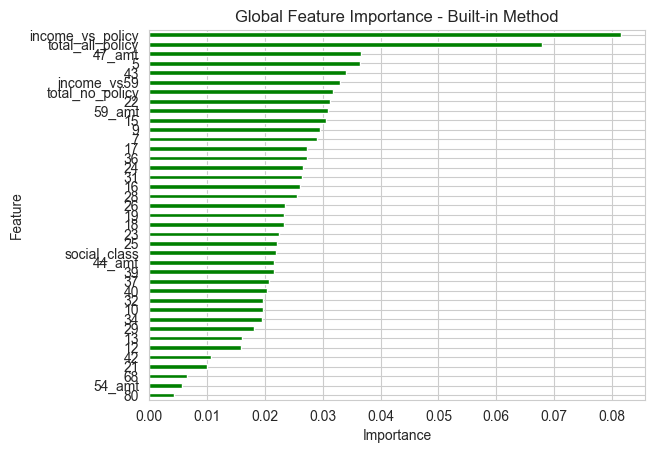

In [255]:
import matplotlib.pyplot as plt
global_importances = pd.Series(clf.feature_importances_, index=X_train.columns)
global_importances.sort_values(ascending=True, inplace=True)
global_importances.plot.barh(color='green')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Global Feature Importance - Built-in Method")

In [276]:
def objective(trial):
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        'random_seed': 100
    }
    clf = CatBoostClassifier(**params, silent=True)
    scores = cross_val_score(clf, X, y, cv=5, scoring='roc_auc')
    final_score = scores.mean()
    print("%0.2f ROC_AUC with a standard deviation of %0.2f" % (scores.mean(), scores.std()))
    return final_score

In [277]:
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=30)

[I 2024-03-15 15:16:51,070] A new study created in memory with name: no-name-67e2eb6e-d1e1-47ab-b50a-04e0cf9350a0
[I 2024-03-15 15:17:21,864] Trial 0 finished with value: 0.7286053736000329 and parameters: {'learning_rate': 0.049517044970143316}. Best is trial 0 with value: 0.7286053736000329.


0.73 ROC_AUC with a standard deviation of 0.03


[I 2024-03-15 15:17:52,503] Trial 1 finished with value: 0.7171300802718367 and parameters: {'learning_rate': 0.08852715847824842}. Best is trial 0 with value: 0.7286053736000329.


0.72 ROC_AUC with a standard deviation of 0.03


[I 2024-03-15 15:18:23,054] Trial 2 finished with value: 0.7279183388100858 and parameters: {'learning_rate': 0.04988067064988698}. Best is trial 0 with value: 0.7286053736000329.


0.73 ROC_AUC with a standard deviation of 0.03


[I 2024-03-15 15:18:54,282] Trial 3 finished with value: 0.7295183373513929 and parameters: {'learning_rate': 0.03897375724102634}. Best is trial 3 with value: 0.7295183373513929.


0.73 ROC_AUC with a standard deviation of 0.02


[I 2024-03-15 15:19:25,274] Trial 4 finished with value: 0.7179823816511364 and parameters: {'learning_rate': 0.07789946932097881}. Best is trial 3 with value: 0.7295183373513929.


0.72 ROC_AUC with a standard deviation of 0.03


[I 2024-03-15 15:19:56,138] Trial 5 finished with value: 0.7625920285992303 and parameters: {'learning_rate': 0.002546036564969167}. Best is trial 5 with value: 0.7625920285992303.


0.76 ROC_AUC with a standard deviation of 0.03


[I 2024-03-15 15:20:27,026] Trial 6 finished with value: 0.7516135274342028 and parameters: {'learning_rate': 0.0010514160934214363}. Best is trial 5 with value: 0.7625920285992303.


0.75 ROC_AUC with a standard deviation of 0.03


[I 2024-03-15 15:20:58,568] Trial 7 finished with value: 0.7536438856337051 and parameters: {'learning_rate': 0.018449577261720276}. Best is trial 5 with value: 0.7625920285992303.


0.75 ROC_AUC with a standard deviation of 0.03


[I 2024-03-15 15:21:30,472] Trial 8 finished with value: 0.7701621744368939 and parameters: {'learning_rate': 0.00425233613894149}. Best is trial 8 with value: 0.7701621744368939.


0.77 ROC_AUC with a standard deviation of 0.03


[I 2024-03-15 15:22:02,785] Trial 9 finished with value: 0.7723932863554711 and parameters: {'learning_rate': 0.00688985675262679}. Best is trial 9 with value: 0.7723932863554711.


0.77 ROC_AUC with a standard deviation of 0.03


[I 2024-03-15 15:22:34,488] Trial 10 finished with value: 0.7734110029587098 and parameters: {'learning_rate': 0.009141883476329738}. Best is trial 10 with value: 0.7734110029587098.


0.77 ROC_AUC with a standard deviation of 0.03


[I 2024-03-15 15:23:05,141] Trial 11 finished with value: 0.7709496034213194 and parameters: {'learning_rate': 0.009105770801376152}. Best is trial 10 with value: 0.7734110029587098.


0.77 ROC_AUC with a standard deviation of 0.03


[I 2024-03-15 15:23:35,790] Trial 12 finished with value: 0.7726718542902656 and parameters: {'learning_rate': 0.008564100392313612}. Best is trial 10 with value: 0.7734110029587098.


0.77 ROC_AUC with a standard deviation of 0.03


[I 2024-03-15 15:24:06,555] Trial 13 finished with value: 0.7548894918613835 and parameters: {'learning_rate': 0.017800955699874683}. Best is trial 10 with value: 0.7734110029587098.


0.75 ROC_AUC with a standard deviation of 0.03


[I 2024-03-15 15:24:37,044] Trial 14 finished with value: 0.7558730143175376 and parameters: {'learning_rate': 0.017325579735952234}. Best is trial 10 with value: 0.7734110029587098.


0.76 ROC_AUC with a standard deviation of 0.03


[I 2024-03-15 15:25:08,136] Trial 15 finished with value: 0.7686416259213464 and parameters: {'learning_rate': 0.003890999346697942}. Best is trial 10 with value: 0.7734110029587098.


0.77 ROC_AUC with a standard deviation of 0.03


[I 2024-03-15 15:25:40,690] Trial 16 finished with value: 0.7726644616898588 and parameters: {'learning_rate': 0.006023410119826291}. Best is trial 10 with value: 0.7734110029587098.


0.77 ROC_AUC with a standard deviation of 0.03


[I 2024-03-15 15:26:11,994] Trial 17 finished with value: 0.7593490761211122 and parameters: {'learning_rate': 0.0016655164402846225}. Best is trial 10 with value: 0.7734110029587098.


0.76 ROC_AUC with a standard deviation of 0.03


[I 2024-03-15 15:26:44,007] Trial 18 finished with value: 0.7680311491428996 and parameters: {'learning_rate': 0.01065002876134832}. Best is trial 10 with value: 0.7734110029587098.


0.77 ROC_AUC with a standard deviation of 0.03


[I 2024-03-15 15:27:18,055] Trial 19 finished with value: 0.7494327939297774 and parameters: {'learning_rate': 0.026084788679405283}. Best is trial 10 with value: 0.7734110029587098.


0.75 ROC_AUC with a standard deviation of 0.03


[I 2024-03-15 15:27:49,970] Trial 20 finished with value: 0.7662084344286163 and parameters: {'learning_rate': 0.012149082811350425}. Best is trial 10 with value: 0.7734110029587098.


0.77 ROC_AUC with a standard deviation of 0.03


[I 2024-03-15 15:28:21,402] Trial 21 finished with value: 0.7738733799240544 and parameters: {'learning_rate': 0.006263343194909156}. Best is trial 21 with value: 0.7738733799240544.


0.77 ROC_AUC with a standard deviation of 0.03


[I 2024-03-15 15:28:54,951] Trial 22 finished with value: 0.7701835806517796 and parameters: {'learning_rate': 0.004462873988298302}. Best is trial 21 with value: 0.7738733799240544.


0.77 ROC_AUC with a standard deviation of 0.03


[I 2024-03-15 15:29:28,448] Trial 23 finished with value: 0.7741254372211664 and parameters: {'learning_rate': 0.007379758435801164}. Best is trial 23 with value: 0.7741254372211664.


0.77 ROC_AUC with a standard deviation of 0.03


[I 2024-03-15 15:30:00,075] Trial 24 finished with value: 0.7639978649505801 and parameters: {'learning_rate': 0.002810093752532619}. Best is trial 23 with value: 0.7741254372211664.


0.76 ROC_AUC with a standard deviation of 0.03


[I 2024-03-15 15:30:32,535] Trial 25 finished with value: 0.7702503721611291 and parameters: {'learning_rate': 0.005267879820464274}. Best is trial 23 with value: 0.7741254372211664.


0.77 ROC_AUC with a standard deviation of 0.03


[I 2024-03-15 15:31:04,485] Trial 26 finished with value: 0.7636599035683 and parameters: {'learning_rate': 0.002870991534739703}. Best is trial 23 with value: 0.7741254372211664.


0.76 ROC_AUC with a standard deviation of 0.03


[I 2024-03-15 15:31:35,824] Trial 27 finished with value: 0.7618105020325001 and parameters: {'learning_rate': 0.01392333145525982}. Best is trial 23 with value: 0.7741254372211664.


0.76 ROC_AUC with a standard deviation of 0.02


[I 2024-03-15 15:32:07,488] Trial 28 finished with value: 0.7719255515972091 and parameters: {'learning_rate': 0.007483552026948368}. Best is trial 23 with value: 0.7741254372211664.


0.77 ROC_AUC with a standard deviation of 0.03


[I 2024-03-15 15:32:39,619] Trial 29 finished with value: 0.7418736445973168 and parameters: {'learning_rate': 0.02776483010856569}. Best is trial 23 with value: 0.7741254372211664.


0.74 ROC_AUC with a standard deviation of 0.02


In [284]:
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 30
Best trial:
  Value: 0.7741254372211664
  Params: 
    learning_rate: 0.007379758435801164


In [288]:
def objective2(trial):
    params_round2 = {
    "learning_rate": 0.007379758435801164,    
    "iterations": trial.suggest_int("iterations", 500, 1000),
    'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1, 100),
    'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 300),
    'bagging_temperature': trial.suggest_loguniform('bagging_temperature', 0.1, 20.0),
    "depth": trial.suggest_int("depth", 1, 8),
    'random_seed': 100
}
    
    clf = CatBoostClassifier(**params_round2, silent=True)
    scores = cross_val_score(clf, X, y, cv=5, scoring='roc_auc')
    final_score = scores.mean()
    print("%0.2f ROC_AUC with a standard deviation of %0.5f" % (scores.mean(), scores.std()))
    return final_score

In [289]:
import warnings
warnings.filterwarnings('ignore')

study2 = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler())
study2.optimize(objective2, n_trials=30)

[I 2024-03-15 15:42:29,916] A new study created in memory with name: no-name-d4eedaa5-f374-4c99-be8d-593d3037657b
[I 2024-03-15 15:42:57,545] Trial 0 finished with value: 0.7698922677505515 and parameters: {'iterations': 763, 'l2_leaf_reg': 2.9882012079454494, 'min_data_in_leaf': 167, 'bagging_temperature': 1.0857125644602899, 'depth': 7}. Best is trial 0 with value: 0.7698922677505515.


0.77 ROC_AUC with a standard deviation of 0.02691


[I 2024-03-15 15:43:19,769] Trial 1 finished with value: 0.7751364302179024 and parameters: {'iterations': 800, 'l2_leaf_reg': 1.7902900562607715, 'min_data_in_leaf': 205, 'bagging_temperature': 1.9603447672358831, 'depth': 5}. Best is trial 1 with value: 0.7751364302179024.


0.78 ROC_AUC with a standard deviation of 0.02893


[I 2024-03-15 15:43:40,473] Trial 2 finished with value: 0.7737489301896011 and parameters: {'iterations': 822, 'l2_leaf_reg': 1.9682586461687326, 'min_data_in_leaf': 241, 'bagging_temperature': 1.394361350944966, 'depth': 4}. Best is trial 1 with value: 0.7751364302179024.


0.77 ROC_AUC with a standard deviation of 0.02791


[I 2024-03-15 15:44:01,657] Trial 3 finished with value: 0.7644599261192776 and parameters: {'iterations': 724, 'l2_leaf_reg': 33.69760735776565, 'min_data_in_leaf': 247, 'bagging_temperature': 0.281510876255901, 'depth': 5}. Best is trial 1 with value: 0.7751364302179024.


0.76 ROC_AUC with a standard deviation of 0.02648


[I 2024-03-15 15:44:24,619] Trial 4 finished with value: 0.7702905703159206 and parameters: {'iterations': 826, 'l2_leaf_reg': 22.75503279705679, 'min_data_in_leaf': 47, 'bagging_temperature': 8.182030207336519, 'depth': 4}. Best is trial 1 with value: 0.7751364302179024.


0.77 ROC_AUC with a standard deviation of 0.02735


[I 2024-03-15 15:44:48,359] Trial 5 finished with value: 0.770412874838496 and parameters: {'iterations': 908, 'l2_leaf_reg': 30.949110549821512, 'min_data_in_leaf': 116, 'bagging_temperature': 0.8711892694937676, 'depth': 4}. Best is trial 1 with value: 0.7751364302179024.


0.77 ROC_AUC with a standard deviation of 0.02641


[I 2024-03-15 15:44:59,141] Trial 6 finished with value: 0.7545498251910356 and parameters: {'iterations': 603, 'l2_leaf_reg': 5.247790188144228, 'min_data_in_leaf': 144, 'bagging_temperature': 3.771563322176959, 'depth': 1}. Best is trial 1 with value: 0.7751364302179024.


0.75 ROC_AUC with a standard deviation of 0.03268


[I 2024-03-15 15:45:23,413] Trial 7 finished with value: 0.7650248060927873 and parameters: {'iterations': 840, 'l2_leaf_reg': 57.819585650102766, 'min_data_in_leaf': 23, 'bagging_temperature': 1.9876930694231607, 'depth': 5}. Best is trial 1 with value: 0.7751364302179024.


0.77 ROC_AUC with a standard deviation of 0.02605


[I 2024-03-15 15:45:46,327] Trial 8 finished with value: 0.7691251261082371 and parameters: {'iterations': 712, 'l2_leaf_reg': 12.166854734550855, 'min_data_in_leaf': 206, 'bagging_temperature': 2.4505290679943026, 'depth': 6}. Best is trial 1 with value: 0.7751364302179024.


0.77 ROC_AUC with a standard deviation of 0.02822


[I 2024-03-15 15:46:00,279] Trial 9 finished with value: 0.7604235019003365 and parameters: {'iterations': 645, 'l2_leaf_reg': 40.98972781781043, 'min_data_in_leaf': 81, 'bagging_temperature': 1.4867066590658728, 'depth': 2}. Best is trial 1 with value: 0.7751364302179024.


0.76 ROC_AUC with a standard deviation of 0.03192


[I 2024-03-15 15:46:42,954] Trial 10 finished with value: 0.761497290140883 and parameters: {'iterations': 967, 'l2_leaf_reg': 1.0028369622850313, 'min_data_in_leaf': 289, 'bagging_temperature': 14.31785647913498, 'depth': 8}. Best is trial 1 with value: 0.7751364302179024.


0.76 ROC_AUC with a standard deviation of 0.02893


[I 2024-03-15 15:46:54,898] Trial 11 finished with value: 0.763773059597509 and parameters: {'iterations': 516, 'l2_leaf_reg': 1.1154436144881057, 'min_data_in_leaf': 219, 'bagging_temperature': 0.3515197018846872, 'depth': 3}. Best is trial 1 with value: 0.7751364302179024.


0.76 ROC_AUC with a standard deviation of 0.03113


[I 2024-03-15 15:47:23,504] Trial 12 finished with value: 0.7734031787649431 and parameters: {'iterations': 843, 'l2_leaf_reg': 2.7248440397803684, 'min_data_in_leaf': 281, 'bagging_temperature': 0.10462022899489837, 'depth': 6}. Best is trial 1 with value: 0.7751364302179024.


0.77 ROC_AUC with a standard deviation of 0.02830


[I 2024-03-15 15:47:45,165] Trial 13 finished with value: 0.773024122477388 and parameters: {'iterations': 909, 'l2_leaf_reg': 2.109773639249514, 'min_data_in_leaf': 201, 'bagging_temperature': 4.337505275273986, 'depth': 3}. Best is trial 1 with value: 0.7751364302179024.


0.77 ROC_AUC with a standard deviation of 0.03079


[I 2024-03-15 15:48:10,159] Trial 14 finished with value: 0.7731881072835459 and parameters: {'iterations': 787, 'l2_leaf_reg': 6.824665406703095, 'min_data_in_leaf': 250, 'bagging_temperature': 0.5974225152713142, 'depth': 6}. Best is trial 1 with value: 0.7751364302179024.


0.77 ROC_AUC with a standard deviation of 0.02941


[I 2024-03-15 15:48:26,667] Trial 15 finished with value: 0.768367108348167 and parameters: {'iterations': 667, 'l2_leaf_reg': 1.755845931593935, 'min_data_in_leaf': 174, 'bagging_temperature': 5.121111670489388, 'depth': 3}. Best is trial 1 with value: 0.7751364302179024.


0.77 ROC_AUC with a standard deviation of 0.03037


[I 2024-03-15 15:48:50,979] Trial 16 finished with value: 0.7732256297046842 and parameters: {'iterations': 904, 'l2_leaf_reg': 4.909641857257987, 'min_data_in_leaf': 244, 'bagging_temperature': 0.5554550306768017, 'depth': 4}. Best is trial 1 with value: 0.7751364302179024.


0.77 ROC_AUC with a standard deviation of 0.02774


[I 2024-03-15 15:49:08,618] Trial 17 finished with value: 0.7613912775936005 and parameters: {'iterations': 999, 'l2_leaf_reg': 11.451967852105717, 'min_data_in_leaf': 109, 'bagging_temperature': 2.474242992939019, 'depth': 1}. Best is trial 1 with value: 0.7751364302179024.


0.76 ROC_AUC with a standard deviation of 0.03034


[I 2024-03-15 15:49:31,028] Trial 18 finished with value: 0.7754745911853227 and parameters: {'iterations': 798, 'l2_leaf_reg': 1.615141520995245, 'min_data_in_leaf': 187, 'bagging_temperature': 17.021174926520555, 'depth': 5}. Best is trial 18 with value: 0.7754745911853227.


0.78 ROC_AUC with a standard deviation of 0.02928


[I 2024-03-15 15:49:52,413] Trial 19 finished with value: 0.7687423925318793 and parameters: {'iterations': 587, 'l2_leaf_reg': 4.357586607217333, 'min_data_in_leaf': 142, 'bagging_temperature': 18.580318744702346, 'depth': 7}. Best is trial 18 with value: 0.7754745911853227.


0.77 ROC_AUC with a standard deviation of 0.02747


[I 2024-03-15 15:50:12,333] Trial 20 finished with value: 0.7581850163581868 and parameters: {'iterations': 698, 'l2_leaf_reg': 93.57465809388572, 'min_data_in_leaf': 171, 'bagging_temperature': 10.545434162371961, 'depth': 5}. Best is trial 18 with value: 0.7754745911853227.


0.76 ROC_AUC with a standard deviation of 0.02870


[I 2024-03-15 15:50:36,989] Trial 21 finished with value: 0.7754776153806655 and parameters: {'iterations': 812, 'l2_leaf_reg': 1.4715303550963559, 'min_data_in_leaf': 222, 'bagging_temperature': 7.668874694774336, 'depth': 5}. Best is trial 21 with value: 0.7754776153806655.


0.78 ROC_AUC with a standard deviation of 0.02783


[I 2024-03-15 15:51:03,082] Trial 22 finished with value: 0.7730396453551112 and parameters: {'iterations': 769, 'l2_leaf_reg': 1.4356239540859912, 'min_data_in_leaf': 189, 'bagging_temperature': 7.062591217059015, 'depth': 6}. Best is trial 21 with value: 0.7754776153806655.


0.77 ROC_AUC with a standard deviation of 0.02853


[I 2024-03-15 15:51:30,818] Trial 23 finished with value: 0.7752008958379359 and parameters: {'iterations': 872, 'l2_leaf_reg': 2.9898089172952362, 'min_data_in_leaf': 219, 'bagging_temperature': 12.35988172169412, 'depth': 5}. Best is trial 21 with value: 0.7754776153806655.


0.78 ROC_AUC with a standard deviation of 0.02647


[I 2024-03-15 15:52:06,080] Trial 24 finished with value: 0.7697242729906466 and parameters: {'iterations': 863, 'l2_leaf_reg': 3.149607850944399, 'min_data_in_leaf': 268, 'bagging_temperature': 12.792202900393516, 'depth': 7}. Best is trial 21 with value: 0.7754776153806655.


0.77 ROC_AUC with a standard deviation of 0.02639


[I 2024-03-15 15:52:34,593] Trial 25 finished with value: 0.7731801680189563 and parameters: {'iterations': 882, 'l2_leaf_reg': 7.921062602113832, 'min_data_in_leaf': 230, 'bagging_temperature': 19.800560580198134, 'depth': 5}. Best is trial 21 with value: 0.7754776153806655.


0.77 ROC_AUC with a standard deviation of 0.02778


[I 2024-03-15 15:53:08,947] Trial 26 finished with value: 0.7741844382042116 and parameters: {'iterations': 948, 'l2_leaf_reg': 1.304264239104137, 'min_data_in_leaf': 267, 'bagging_temperature': 7.331990455147623, 'depth': 6}. Best is trial 21 with value: 0.7754776153806655.


0.77 ROC_AUC with a standard deviation of 0.02765


[I 2024-03-15 15:53:44,792] Trial 27 finished with value: 0.7665493442026005 and parameters: {'iterations': 739, 'l2_leaf_reg': 3.4693906612802476, 'min_data_in_leaf': 220, 'bagging_temperature': 10.477200323574024, 'depth': 8}. Best is trial 21 with value: 0.7754776153806655.


0.77 ROC_AUC with a standard deviation of 0.02654


[I 2024-03-15 15:54:06,676] Trial 28 finished with value: 0.7696040260201091 and parameters: {'iterations': 804, 'l2_leaf_reg': 2.3174229066631575, 'min_data_in_leaf': 185, 'bagging_temperature': 5.79766672104982, 'depth': 3}. Best is trial 21 with value: 0.7754776153806655.


0.77 ROC_AUC with a standard deviation of 0.03063


[I 2024-03-15 15:54:38,018] Trial 29 finished with value: 0.7670161223071841 and parameters: {'iterations': 764, 'l2_leaf_reg': 15.72810060975277, 'min_data_in_leaf': 133, 'bagging_temperature': 3.642209682404989, 'depth': 7}. Best is trial 21 with value: 0.7754776153806655.


0.77 ROC_AUC with a standard deviation of 0.02586


In [290]:
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial2 = study2.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial2.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 30
Best trial:
  Value: 0.7741254372211664
  Params: 
    iterations: 812
    l2_leaf_reg: 1.4715303550963559
    min_data_in_leaf: 222
    bagging_temperature: 7.668874694774336
    depth: 5


In [293]:
trial2.params

{'iterations': 812,
 'l2_leaf_reg': 1.4715303550963559,
 'min_data_in_leaf': 222,
 'bagging_temperature': 7.668874694774336,
 'depth': 5}

In [303]:
final_clf = CatBoostClassifier(**trial2.params, silent=True, random_seed=100)
final_clf.fit(X, y)

In [308]:
import pickle
filename = 'models/CatBoostTrial1.sav'
pickle.dump(final_clf, open(filename, 'wb'))

# Conformal prediction

# Interpretation